In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from util.plotting import *
from datetime import date, datetime, time, timedelta
import json
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import PercentFormatter
import warnings
from scipy.stats import gmean
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


## Load incident data

In [2]:
# load incident data
path = f'data/clean/incident/2024-08-31/incident_stages.csv'
df = pd.read_csv(path)

status_lst = ['investigating', 'identified', 'monitoring', 'resolved', 'postmortem', 'start']
for status in status_lst:
    df[f'{status}_timestamp'] = pd.to_datetime(df[f'{status}_timestamp'])

df.head()

,incident_id,Incident_Title,incident_impact_level,Incident_color,provider,Playground,API,Labs,ChatGPT,api.anthropic.com,claude.ai,console.anthropic.com,Character.AI,investigating_flag,investigating_timestamp,investigating_description,identified_flag,identified_timestamp,identified_description,monitoring_flag,monitoring_timestamp,monitoring_description,resolved_flag,resolved_timestamp,resolved_description,postmortem_flag,postmortem_timestamp,postmortem_description,start_timestamp,close_timestamp,time_span,over_one_day
0,qv89mzdjvtrs,Elevated Errors,1,#f1c40f,anthropic,0,0,0,0,1,1,1,0,1,2024-02-26 17:09:00+00:00,We're experiencing an elevated level of API er...,1,2024-02-26 17:37:00+00:00,The issue has been identified and a fix is bei...,1,2024-02-26 17:41:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-26 18:21:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-26 17:09:00+00:00,2024-02-26 18:21:00+00:00,0 days 01:12:00,False
1,tmsczhzhjd63,Elevated error rate on claude.ai,0,#333333,anthropic,0,0,0,0,0,0,0,0,0,NaT,NaN,0,NaT,NaN,0,NaT,NaN,1,2024-02-16 20:35:00+00:00,We experienced an elevated level of errors on ...,0,NaT,NaN,2024-02-16 20:35:00+00:00,2024-02-16 20:35:00+00:00,0 days 00:00:00,False
2,t6v85cs8j6jb,"Elevated error rate on Claude-2.0, Claude-2.1",0,#333333,anthropic,0,0,0,0,1,1,1,0,1,2024-02-13 03:59:00+00:00,We are currently investigating this issue.,1,2024-02-13 04:21:00+00:00,The issue has been identified and a fix is bei...,1,2024-02-13 04:30:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-13 04:36:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-13 03:59:00+00:00,2024-02-13 04:36:00+00:00,0 days 00:37:00,False
3,x5f4s8nvkyqq,"Elevated error rate on Claude-2.0, Claude-2.1",0,#333333,anthropic,0,0,0,0,1,1,1,0,1,2024-02-13 00:21:00+00:00,We are currently investigating this issue.,1,2024-02-13 00:50:00+00:00,The issue has been identified and a fix is bei...,1,2024-02-13 00:59:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-13 01:26:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-13 00:21:00+00:00,2024-02-13 01:26:00+00:00,0 days 01:05:00,False
4,gr7nb0dwyydw,elevated error rates on claude-instant-1.2,0,#333333,anthropic,0,0,0,0,1,1,1,0,1,2024-02-05 23:07:00+00:00,We are currently investigating this issue.,0,NaT,NaN,1,2024-02-05 23:58:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-06 01:55:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-05 23:07:00+00:00,2024-02-06 01:55:00+00:00,0 days 02:48:00,False


In [3]:
# filter out df corner cases
count_lst = 5 * [0]
corner_cases = pd.DataFrame()

for index, record in df.iterrows():
    if record['investigating_timestamp'] > record['identified_timestamp']:
        count_lst[0] += 1
        corner_cases = pd.concat([corner_cases, record], axis=0)
    if record['identified_timestamp'] > record['monitoring_timestamp']:
        count_lst[1] += 1
        corner_cases = pd.concat([corner_cases, record], axis=0)
    if record['monitoring_timestamp'] > record['resolved_timestamp']:
        count_lst[2] += 1
        corner_cases = pd.concat([corner_cases, record], axis=0)
    if record['resolved_timestamp'] > record['postmortem_timestamp']:
        count_lst[3] += 1
        corner_cases = pd.concat([corner_cases, record], axis=0)
print(count_lst)

# transposing corner cases
corner_cases = corner_cases.T
# display(corner_cases)

# filter out df corner cases
df = df.drop(corner_cases.index)
df = df.reset_index(drop=True)

df.head()

[2, 3, 0, 0, 0]


,incident_id,Incident_Title,incident_impact_level,Incident_color,provider,Playground,API,Labs,ChatGPT,api.anthropic.com,claude.ai,console.anthropic.com,Character.AI,investigating_flag,investigating_timestamp,investigating_description,identified_flag,identified_timestamp,identified_description,monitoring_flag,monitoring_timestamp,monitoring_description,resolved_flag,resolved_timestamp,resolved_description,postmortem_flag,postmortem_timestamp,postmortem_description,start_timestamp,close_timestamp,time_span,over_one_day
0,qv89mzdjvtrs,Elevated Errors,1,#f1c40f,anthropic,0,0,0,0,1,1,1,0,1,2024-02-26 17:09:00+00:00,We're experiencing an elevated level of API er...,1,2024-02-26 17:37:00+00:00,The issue has been identified and a fix is bei...,1,2024-02-26 17:41:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-26 18:21:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-26 17:09:00+00:00,2024-02-26 18:21:00+00:00,0 days 01:12:00,False
1,tmsczhzhjd63,Elevated error rate on claude.ai,0,#333333,anthropic,0,0,0,0,0,0,0,0,0,NaT,NaN,0,NaT,NaN,0,NaT,NaN,1,2024-02-16 20:35:00+00:00,We experienced an elevated level of errors on ...,0,NaT,NaN,2024-02-16 20:35:00+00:00,2024-02-16 20:35:00+00:00,0 days 00:00:00,False
2,t6v85cs8j6jb,"Elevated error rate on Claude-2.0, Claude-2.1",0,#333333,anthropic,0,0,0,0,1,1,1,0,1,2024-02-13 03:59:00+00:00,We are currently investigating this issue.,1,2024-02-13 04:21:00+00:00,The issue has been identified and a fix is bei...,1,2024-02-13 04:30:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-13 04:36:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-13 03:59:00+00:00,2024-02-13 04:36:00+00:00,0 days 00:37:00,False
3,x5f4s8nvkyqq,"Elevated error rate on Claude-2.0, Claude-2.1",0,#333333,anthropic,0,0,0,0,1,1,1,0,1,2024-02-13 00:21:00+00:00,We are currently investigating this issue.,1,2024-02-13 00:50:00+00:00,The issue has been identified and a fix is bei...,1,2024-02-13 00:59:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-13 01:26:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-13 00:21:00+00:00,2024-02-13 01:26:00+00:00,0 days 01:05:00,False
4,gr7nb0dwyydw,elevated error rates on claude-instant-1.2,0,#333333,anthropic,0,0,0,0,1,1,1,0,1,2024-02-05 23:07:00+00:00,We are currently investigating this issue.,0,NaT,NaN,1,2024-02-05 23:58:00+00:00,A fix has been implemented and we are monitori...,1,2024-02-06 01:55:00+00:00,This incident has been resolved.,0,NaT,NaN,2024-02-05 23:07:00+00:00,2024-02-06 01:55:00+00:00,0 days 02:48:00,False


## table. status count of incidents

In [162]:
# table. status counts
count_dict = {}

# let S1 = investigating, S2 = identified, S3 = monitoring, S4 = resolved, S5 = postmortem

for index, record in df.iterrows():
    if record['investigating_flag'] == 1 and record['identified_flag'] == 1 and record['monitoring_flag'] == 1 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 1:
        count_dict['S1_S2_S3_S4_S5'] = count_dict.get('S1_S2_S3_S4_S5', 0) + 1
    elif record['investigating_flag'] == 1 and record['identified_flag'] == 1 and record['monitoring_flag'] == 1 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 0:
        count_dict['S1_S2_S3_S4'] = count_dict.get('S1_S2_S3_S4', 0) + 1
    elif record['investigating_flag'] == 1 and record['identified_flag'] == 1 and record['monitoring_flag'] == 0 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 1:
        count_dict['S1_S2_S4_S5'] = count_dict.get('S1_S2_S4_S5', 0) + 1
    elif record['investigating_flag'] == 1 and record['identified_flag'] == 0 and record['monitoring_flag'] == 1 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 1:
        count_dict['S1_S3_S4_S5'] = count_dict.get('S1_S3_S4_S5', 0) + 1
    elif record['investigating_flag'] == 0 and record['identified_flag'] == 1 and record['monitoring_flag'] == 1 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 1:
        count_dict['S2_S3_S4_S5'] = count_dict.get('S2_S3_S4_S5', 0) + 1
    elif record['investigating_flag'] == 1 and record['identified_flag'] == 0 and record['monitoring_flag'] == 0 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 1:
        count_dict['S1_S4_S5'] = count_dict.get('S1_S4_S5', 0) + 1
    elif record['investigating_flag'] == 0 and record['identified_flag'] == 1 and record['monitoring_flag'] == 0 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 1:
        count_dict['S2_S4_S5'] = count_dict.get('S2_S4_S5', 0) + 1
    elif record['investigating_flag'] == 0 and record['identified_flag'] == 0 and record['monitoring_flag'] == 1 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 1:
        count_dict['S3_S4_S5'] = count_dict.get('S3_S4_S5', 0) + 1
    elif record['investigating_flag'] == 0 and record['identified_flag'] == 1 and record['monitoring_flag'] == 1 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 0:
        count_dict['S2_S3_S4'] = count_dict.get('S2_S3_S4', 0) + 1
    elif record['investigating_flag'] == 1 and record['identified_flag'] == 0 and record['monitoring_flag'] == 1 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 0:
        count_dict['S1_S3_S4'] = count_dict.get('S1_S3_S4', 0) + 1
    elif record['investigating_flag'] == 1 and record['identified_flag'] == 1 and record['monitoring_flag'] == 0 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 0:
        count_dict['S1_S2_S4'] = count_dict.get('S1_S2_S4', 0) + 1
    elif record['investigating_flag'] == 0 and record['identified_flag'] == 0 and record['monitoring_flag'] == 0 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 1:
        count_dict['S4_S5'] = count_dict.get('S4_S5', 0) + 1
    elif record['investigating_flag'] == 1 and record['identified_flag'] == 0 and record['monitoring_flag'] == 0 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 0:
        count_dict['S1_S4'] = count_dict.get('S1_S4', 0) + 1
    elif record['investigating_flag'] == 0 and record['identified_flag'] == 1 and record['monitoring_flag'] == 0 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 0:
        count_dict['S2_S4'] = count_dict.get('S2_S4', 0) + 1
    elif record['investigating_flag'] == 0 and record['identified_flag'] == 0 and record['monitoring_flag'] == 1 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 0:
        count_dict['S3_S4'] = count_dict.get('S3_S4', 0) + 1
    elif record['investigating_flag'] == 0 and record['identified_flag'] == 0 and record['monitoring_flag'] == 0 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 0:
        count_dict['S4'] = count_dict.get('S4', 0) + 1

print(count_dict)

{'S1_S2_S3_S4': 77, 'S4': 62, 'S1_S3_S4': 131, 'S3_S4': 18, 'S4_S5': 4, 'S1_S4': 110, 'S2_S3_S4': 39, 'S1_S2_S4': 35, 'S2_S4': 32, 'S2_S4_S5': 2, 'S1_S2_S3_S4_S5': 12, 'S1_S3_S4_S5': 7, 'S2_S3_S4_S5': 3, 'S1_S4_S5': 5}


In [163]:
# sum of all counts
sum_all = sum(count_dict.values())
print(sum_all)
# sort by values
count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))

# transform to df
count_df = pd.DataFrame(count_dict.items(), columns=['case', 'count'])
count_df['percentage'] = count_df['count'] / sum_all
count_df['percentage'] = count_df['percentage'].map(lambda x: '{:.2%}'.format(x))
# add row of sum_all to the last row
sum_all = pd.DataFrame({'case': 'sum_all', 'count': sum_all, 'percentage': '100.00%'}, index=[0])
count_df = pd.concat([count_df, sum_all], axis=0)
display(count_df)

# split case into stages
for index, record in count_df.iterrows():
    if record['case'] == 'sum_all':
        continue
    if 'S1' in record['case']:
        count_df.loc[index, 'investigating'] = 1
    if 'S2' in record['case']:
        count_df.loc[index, 'identified'] = 1
    if 'S3' in record['case']:
        count_df.loc[index, 'monitoring'] = 1
    if 'S4' in record['case']:
        count_df.loc[index, 'resolved'] = 1
    if 'S5' in record['case']:
        count_df.loc[index, 'postmortem'] = 1
count_df = count_df.fillna(0)
count_df = count_df.astype({'investigating': int, 'identified': int, 'monitoring': int, 'resolved': int, 'postmortem': int})
count_df_reorder = count_df[['investigating', 'identified', 'monitoring', 'resolved', 'postmortem', 'count', 'percentage']]
count_df_reorder

537


,case,count,percentage
0,S1_S3_S4,131,24.39%
1,S1_S4,110,20.48%
2,S1_S2_S3_S4,77,14.34%
3,S4,62,11.55%
4,S2_S3_S4,39,7.26%
5,S1_S2_S4,35,6.52%
6,S2_S4,32,5.96%
7,S3_S4,18,3.35%
8,S1_S2_S3_S4_S5,12,2.23%
9,S1_S3_S4_S5,7,1.30%


,investigating,identified,monitoring,resolved,postmortem,count,percentage
0,1,0,1,1,0,131,24.39%
1,1,0,0,1,0,110,20.48%
2,1,1,1,1,0,77,14.34%
3,0,0,0,1,0,62,11.55%
4,0,1,1,1,0,39,7.26%
5,1,1,0,1,0,35,6.52%
6,0,1,0,1,0,32,5.96%
7,0,0,1,1,0,18,3.35%
8,1,1,1,1,1,12,2.23%
9,1,0,1,1,1,7,1.30%


In [37]:
# save to csv
count_df_reorder.to_csv('plot/backup_table_csv/table-incident-status-count.csv', index=False)

In [173]:
# nubmer for observations
case_with_postmortem = count_df_reorder[count_df_reorder['postmortem'] == 1]['count'].sum()
percentage_with_postmortem = case_with_postmortem / (count_df_reorder['count'].sum()/2)
print(f'Number of observations with postmortem: {case_with_postmortem}')
print(f'Percentage of observations with postmortem: {percentage_with_postmortem:.2%}')

Number of observations with postmortem: 33
Percentage of observations with postmortem: 6.15%


## figure. percent of status count combinations by service [stack bar].

In [77]:
df = df.rename(columns={'API': 'API-OpenAI', 'ChatGPT': 'ChatGPT', 'Labs': 'DALL·E', 'Playground': 'Playground', 'api.anthropic.com': 'API-Anthropic', 'claude.ai': 'Claude', 'console.anthropic.com': 'Console', 'Character.AI': 'Character.AI'})
service_lst = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI']
dfs = {}
for service in service_lst:
    dfs[service] = df[df[service] == 1]
count_dict_lst = {}

# let S1 = investigating, S2 = identified, S3 = monitoring, S4 = resolved, S5 = postmortem
for service in service_lst:
    count_dict = {}
    for index, record in dfs[service].iterrows():
        if record['investigating_flag'] == 1 and record['identified_flag'] == 1 and record['monitoring_flag'] == 1 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 1:
            count_dict['S1_S2_S3_S4_S5'] = count_dict.get('S1_S2_S3_S4_S5', 0) + 1
        elif record['investigating_flag'] == 1 and record['identified_flag'] == 1 and record['monitoring_flag'] == 1 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 0:
            count_dict['S1_S2_S3_S4'] = count_dict.get('S1_S2_S3_S4', 0) + 1
        elif record['investigating_flag'] == 1 and record['identified_flag'] == 1 and record['monitoring_flag'] == 0 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 1:
            count_dict['S1_S2_S4_S5'] = count_dict.get('S1_S2_S4_S5', 0) + 1
        elif record['investigating_flag'] == 1 and record['identified_flag'] == 0 and record['monitoring_flag'] == 1 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 1:
            count_dict['S1_S3_S4_S5'] = count_dict.get('S1_S3_S4_S5', 0) + 1
        elif record['investigating_flag'] == 0 and record['identified_flag'] == 1 and record['monitoring_flag'] == 1 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 1:
            count_dict['S2_S3_S4_S5'] = count_dict.get('S2_S3_S4_S5', 0) + 1
        elif record['investigating_flag'] == 1 and record['identified_flag'] == 0 and record['monitoring_flag'] == 0 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 1:
            count_dict['S1_S4_S5'] = count_dict.get('S1_S4_S5', 0) + 1
        elif record['investigating_flag'] == 0 and record['identified_flag'] == 1 and record['monitoring_flag'] == 0 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 1:
            count_dict['S2_S4_S5'] = count_dict.get('S2_S4_S5', 0) + 1
        elif record['investigating_flag'] == 0 and record['identified_flag'] == 0 and record['monitoring_flag'] == 1 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 1:
            count_dict['S3_S4_S5'] = count_dict.get('S3_S4_S5', 0) + 1
        elif record['investigating_flag'] == 0 and record['identified_flag'] == 1 and record['monitoring_flag'] == 1 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 0:
            count_dict['S2_S3_S4'] = count_dict.get('S2_S3_S4', 0) + 1
        elif record['investigating_flag'] == 1 and record['identified_flag'] == 0 and record['monitoring_flag'] == 1 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 0:
            count_dict['S1_S3_S4'] = count_dict.get('S1_S3_S4', 0) + 1
        elif record['investigating_flag'] == 1 and record['identified_flag'] == 1 and record['monitoring_flag'] == 0 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 0:
            count_dict['S1_S2_S4'] = count_dict.get('S1_S2_S4', 0) + 1
        elif record['investigating_flag'] == 0 and record['identified_flag'] == 0 and record['monitoring_flag'] == 0 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 1:
            count_dict['S4_S5'] = count_dict.get('S4_S5', 0) + 1
        elif record['investigating_flag'] == 1 and record['identified_flag'] == 0 and record['monitoring_flag'] == 0 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 0:
            count_dict['S1_S4'] = count_dict.get('S1_S4', 0) + 1
        elif record['investigating_flag'] == 0 and record['identified_flag'] == 1 and record['monitoring_flag'] == 0 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 0:
            count_dict['S2_S4'] = count_dict.get('S2_S4', 0) + 1
        elif record['investigating_flag'] == 0 and record['identified_flag'] == 0 and record['monitoring_flag'] == 1 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 0:
            count_dict['S3_S4'] = count_dict.get('S3_S4', 0) + 1
        elif record['investigating_flag'] == 0 and record['identified_flag'] == 0 and record['monitoring_flag'] == 0 and record['resolved_flag'] == 1 and record['postmortem_flag'] == 0:
            count_dict['S4'] = count_dict.get('S4', 0) + 1
    # transform to df
    count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))
    count_df = pd.DataFrame(count_dict.items(), columns=['case', f'{service}'])
    count_dict_lst[service] = count_df

# display(count_dict_lst['API-OpenAI'])
# concat all df in count_dict_lst
print('table. incident status count by service.')
case_df = count_dict_lst['API-OpenAI']
for service in service_lst[1:]:
    case_df = pd.merge(case_df, count_dict_lst[service], on='case', how='outer')
case_df = case_df.fillna(0)
case_df['sum'] = case_df.iloc[:, 1:].sum(axis=1)
case_df = case_df.sort_values(by='sum', ascending=False)
case_df = case_df.reset_index(drop=True)
case_df = case_df.set_index('case')
case_df = case_df.T
display(case_df)

# transform to percentage
print('table. incident status count by service in percentage.')
case_df['sum_all'] = case_df.sum(axis=1)
for column in case_df.columns:
    case_df[column] = case_df[column] / case_df['sum_all']
case_df = case_df.drop(columns='sum_all')
case_df = case_df.drop(index='sum')
case_df = case_df.reset_index()
case_df = case_df.rename(columns={'index': 'service'})
case_df = case_df.round(4)
display(case_df)

# sum all columns with S5
case_df['All_with_S5'] = case_df['S1_S2_S3_S4_S5'] + case_df['S1_S3_S4_S5'] + case_df['S2_S3_S4_S5'] + case_df['S1_S4_S5'] + case_df['S2_S4_S5'] + case_df['S4_S5']
# drop columns
case_df = case_df.drop(columns=['S1_S2_S3_S4_S5', 'S1_S3_S4_S5', 'S2_S3_S4_S5', 'S1_S4_S5', 'S2_S4_S5', 'S4_S5'])
# # reverse the order of rows for horizontal bar plot
# case_df = case_df.iloc[::-1]
display(case_df)

table. incident status count by service.


case,S1_S3_S4,S1_S4,S1_S2_S3_S4,S2_S3_S4,S1_S2_S4,S2_S4,S4,S3_S4,S1_S2_S3_S4_S5,S1_S3_S4_S5,S1_S4_S5,S2_S3_S4_S5,S2_S4_S5,S4_S5
API-OpenAI,68.0,41.0,30.0,25.0,15.0,14.0,8.0,8.0,7.0,5.0,2.0,3.0,0.0,1.0
ChatGPT,58.0,13.0,19.0,11.0,11.0,9.0,3.0,3.0,6.0,6.0,2.0,0.0,0.0,0.0
DALL·E,12.0,6.0,6.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0
Playground,10.0,5.0,6.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
API-Anthropic,9.0,28.0,17.0,4.0,7.0,4.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
Claude,15.0,31.0,19.0,3.0,5.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0
Console,13.0,29.0,14.0,2.0,5.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Character.AI,8.0,11.0,5.0,1.0,1.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
sum,193.0,164.0,116.0,51.0,47.0,42.0,24.0,22.0,16.0,13.0,5.0,3.0,2.0,2.0


table. incident status count by service in percentage.


case,service,S1_S3_S4,S1_S4,S1_S2_S3_S4,S2_S3_S4,S1_S2_S4,S2_S4,S4,S3_S4,S1_S2_S3_S4_S5,S1_S3_S4_S5,S1_S4_S5,S2_S3_S4_S5,S2_S4_S5,S4_S5
0,API-OpenAI,0.2996,0.1806,0.1322,0.1101,0.0661,0.0617,0.0352,0.0352,0.0308,0.0220,0.0088,0.0132,0.0000,0.0044
1,ChatGPT,0.4113,0.0922,0.1348,0.0780,0.0780,0.0638,0.0213,0.0213,0.0426,0.0426,0.0142,0.0000,0.0000,0.0000
2,DALL·E,0.3871,0.1935,0.1935,0.0645,0.0323,0.0000,0.0000,0.0000,0.0645,0.0323,0.0323,0.0000,0.0000,0.0000
3,Playground,0.3125,0.1562,0.1875,0.0938,0.0625,0.0312,0.0625,0.0312,0.0312,0.0312,0.0000,0.0000,0.0000,0.0000
4,API-Anthropic,0.1184,0.3684,0.2237,0.0526,0.0921,0.0526,0.0526,0.0395,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,Claude,0.1744,0.3605,0.2209,0.0349,0.0581,0.0465,0.0465,0.0465,0.0000,0.0000,0.0000,0.0000,0.0000,0.0116
6,Console,0.1806,0.4028,0.1944,0.0278,0.0694,0.0556,0.0417,0.0278,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,Character.AI,0.2286,0.3143,0.1429,0.0286,0.0286,0.1714,0.0000,0.0286,0.0000,0.0000,0.0000,0.0000,0.0571,0.0000


case,service,S1_S3_S4,S1_S4,S1_S2_S3_S4,S2_S3_S4,S1_S2_S4,S2_S4,S4,S3_S4,All_with_S5
0,API-OpenAI,0.2996,0.1806,0.1322,0.1101,0.0661,0.0617,0.0352,0.0352,0.0792
1,ChatGPT,0.4113,0.0922,0.1348,0.0780,0.0780,0.0638,0.0213,0.0213,0.0994
2,DALL·E,0.3871,0.1935,0.1935,0.0645,0.0323,0.0000,0.0000,0.0000,0.1291
3,Playground,0.3125,0.1562,0.1875,0.0938,0.0625,0.0312,0.0625,0.0312,0.0624
4,API-Anthropic,0.1184,0.3684,0.2237,0.0526,0.0921,0.0526,0.0526,0.0395,0.0000
5,Claude,0.1744,0.3605,0.2209,0.0349,0.0581,0.0465,0.0465,0.0465,0.0116
6,Console,0.1806,0.4028,0.1944,0.0278,0.0694,0.0556,0.0417,0.0278,0.0000
7,Character.AI,0.2286,0.3143,0.1429,0.0286,0.0286,0.1714,0.0000,0.0286,0.0571


figure. stacked bar plot of incident status count by service.


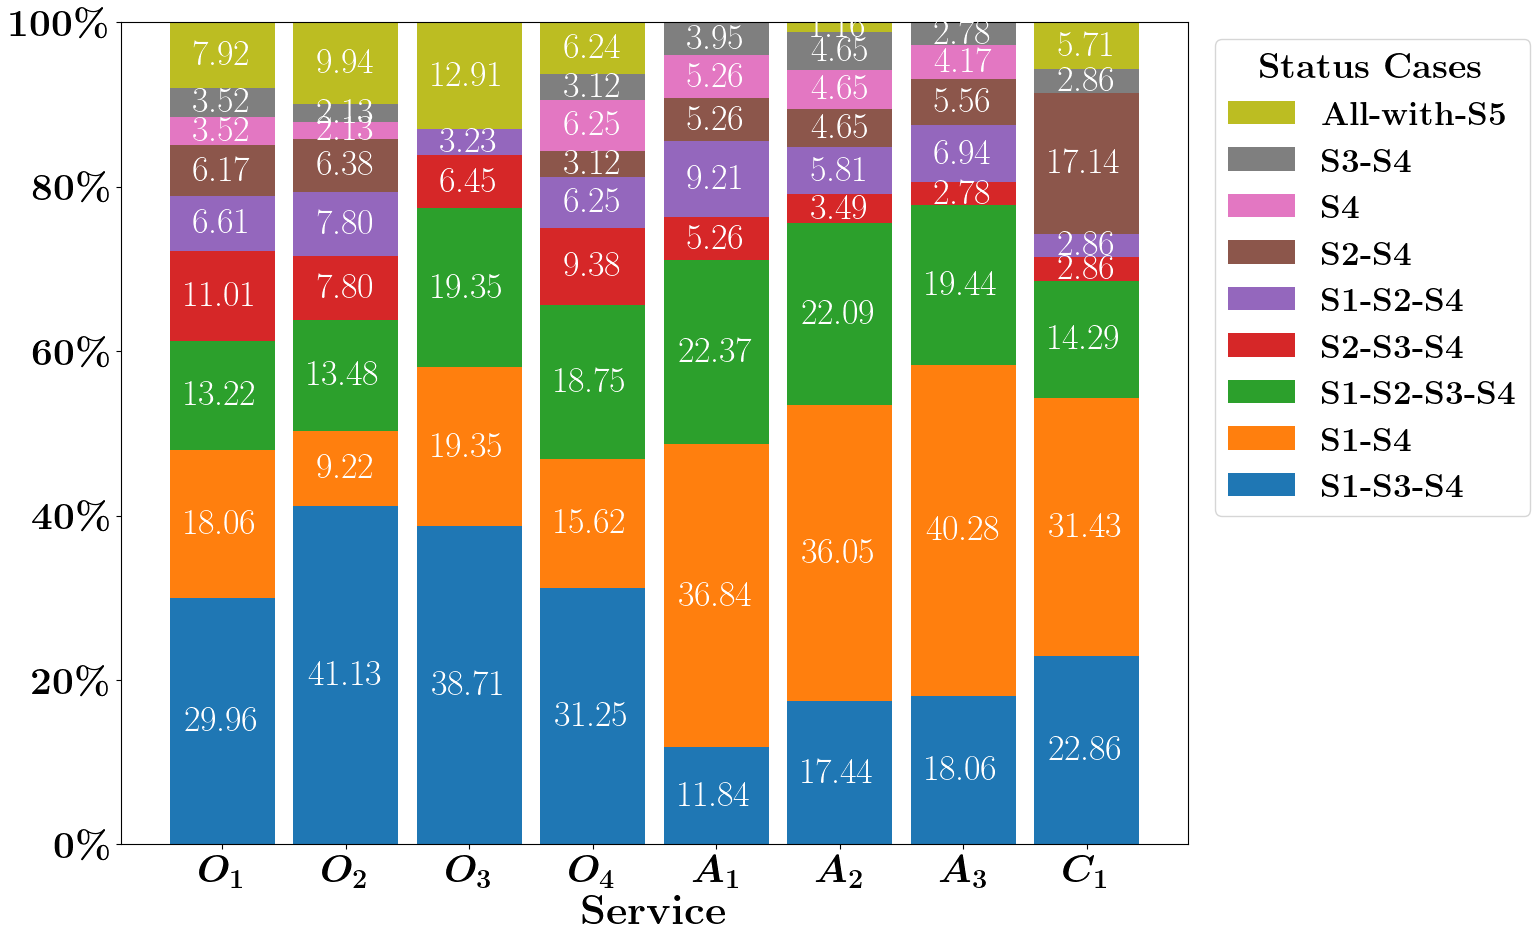

In [110]:
# figure. stacked bar plot of incident status count by service
print('figure. stacked bar plot of incident status count by service.')
fig, ax = plt.subplots(figsize=(16, 10))
barWidth = 0.85
bottom = [0] * len(case_df)
colors = sns.color_palette('tab10', n_colors=len(case_df.columns[1:]))
for column in case_df.columns[1:]:
    ax.bar(case_df['service'], case_df[column], bottom=bottom, label=column, color=colors.pop(0), width=barWidth)
    # add percentage text in the middle of each bar, such as 0.00%
    for index, value in enumerate(case_df[column]):
        if value == 0:
            continue
        ax.text(index, bottom[index] + value / 2, f'{value:.2%}', ha='center', va='center', color='white', fontsize=26)
    bottom = [sum(x) for x in zip(bottom, case_df[column])]

labels = [r'\textbf{S1-S3-S4}', r'\textbf{S1-S4}', r'\textbf{S1-S2-S3-S4}', r'\textbf{S2-S3-S4}', r'\textbf{S1-S2-S4}', r'\textbf{S2-S4}', r'\textbf{S4}', r'\textbf{S3-S4}', r'\textbf{All-with-S5}']
reversed_labels = labels[::-1]
# reverse the legend order
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed_labels, title=r'\textbf{Status Cases}', bbox_to_anchor=(1.01, 1.0), loc='upper left')
ax.set_xlabel(r'\textbf{Service}', fontsize=30)
y_tick_lst = [r'\textbf{0\%}', r'\textbf{20\%}', r'\textbf{40\%}', r'\textbf{60\%}', r'\textbf{80\%}', r'\textbf{100\%}']
ax.set_yticklabels(y_tick_lst, fontsize=28)
x_tick_service_lst = [r'\textbf{$O_1$}', r'\textbf{$O_2$}', r'\textbf{$O_3$}', r'\textbf{$O_4$}', r'\textbf{$A_1$}', r'\textbf{$A_2$}', r'\textbf{$A_3$}', r'\textbf{$C_1$}']
# x_tick_service_lst = [r'\textbf{API-OpenAI}', r'\textbf{ChatGPT}', r'\textbf{DALL·E}', r'\textbf{Playground}', r'\textbf{API-Anthropic}', r'\textbf{Claude}', r'\textbf{Console}', r'\textbf{Character.AI}']
ax.set_xticklabels(x_tick_service_lst, fontsize=28)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('plot/sec4-failure_recovery/stacked_bar_incident_status_count_by_service.pdf')
plt.show()


## table. Mean value for model parameters by service. 

In [ ]:
# calculate the duration of each stage and add new columns
df = df.rename(columns={'API': 'API-OpenAI', 'ChatGPT': 'ChatGPT', 'Labs': 'DALL·E', 'Playground': 'Playground', 'api.anthropic.com': 'API-Anthropic', 'claude.ai': 'Claude', 'console.anthropic.com': 'Console', 'Character.AI': 'Character.AI'})
service_lst = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI']
dfs = {}
for service in service_lst:
    dfs[service] = df[df[service] == 1]
    # order by investigating_timestamp
    dfs[service] = dfs[service].sort_values(by='start_timestamp')
    dfs[service] = dfs[service].reset_index(drop=True)
for service in service_lst:
    dfs[service]['MTBF'] = dfs[service]['start_timestamp'].diff()
    dfs[service]['P_investigate'] = dfs[service]['identified_timestamp'] - dfs[service]['investigating_timestamp']
    dfs[service]['P_repair'] = dfs[service]['monitoring_timestamp'] - dfs[service]['identified_timestamp']
    dfs[service]['P_check'] = dfs[service]['resolved_timestamp'] - dfs[service]['monitoring_timestamp']
    dfs[service]['P_learn'] = dfs[service]['postmortem_timestamp'] - dfs[service]['resolved_timestamp']
    dfs[service]['MTTR'] = dfs[service]['resolved_timestamp'] - dfs[service][['investigating_timestamp', 'identified_timestamp', 'monitoring_timestamp']].min(axis=1)
    dfs[service] = dfs[service].reset_index(drop=True)

dfs['API-OpenAI'].head()

In [67]:
# table. mean duration of model parameters grouped by service.
print('mean duration of model parameters by service [hours]')
# service_lst = ['API', 'ChatGPT', 'Labs', 'Playground', 'api.anthropic.com', 'claude.ai', 'console.anthropic.com', 'Character.AI']
service_lst = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI']

duration_dict = {}
for service in service_lst:
    duration_dict[service] = {}
    for period in ['P_investigate', 'P_repair', 'P_check', 'P_learn', 'MTTR', 'MTBF']:
        duration_dict[service][period] = dfs[service][period].mean()
duration_df = pd.DataFrame(duration_dict)
duration_df = duration_df.T
duration_df = duration_df.reset_index()
duration_df = duration_df.rename(columns={'index': 'service'})

# transform to hours
for period in ['P_investigate', 'P_repair', 'P_check', 'P_learn', 'MTTR', 'MTBF']:
    duration_df[period] = duration_df[period].map(lambda x: x.total_seconds() / 60 / 60)

# add a row of arithmetic average
df_all = pd.concat([dfs['API-OpenAI'], dfs['ChatGPT'], dfs['DALL·E'], dfs['Playground'], dfs['API-Anthropic'], dfs['Claude'], dfs['Console'], dfs['Character.AI']], axis=0)
for period in ['P_investigate', 'P_repair', 'P_check', 'P_learn', 'MTTR', 'MTBF']:
    arith_avg = df_all[period].mean()
    duration_df.loc[8, period] = arith_avg.total_seconds() / 60 / 60
duration_df.loc[8, 'service'] = 'Arith. Mean'

# add a row of geometric average
df_all = pd.concat([dfs['API-OpenAI'], dfs['ChatGPT'], dfs['DALL·E'], dfs['Playground'], dfs['API-Anthropic'], dfs['Claude'], dfs['Console'], dfs['Character.AI']], axis=0)
df_all = df_all.reset_index(drop=True)
for period in ['P_investigate', 'P_repair', 'P_check', 'P_learn', 'MTTR', 'MTBF']:
    df_all[period] = df_all[period].map(lambda x: x.total_seconds() / 60 / 60)
    df_all = df_all.dropna()
    geom_avg = gmean(df_all[period])
    duration_df.loc[9, period] = geom_avg
duration_df.loc[9, 'service'] = 'Geom. Mean'

# transform to days
duration_df['P_learn'] = duration_df['P_learn'] / 24
duration_df['MTBF'] = duration_df['MTBF'] / 24

duration_df = duration_df.round(2)
display(duration_df)


mean duration of model parameters by service [hours]


,service,P_investigate,P_repair,P_check,P_learn,MTTR,MTBF
0,API-OpenAI,0.72,1.63,1.46,4.10,2.56,5.64
1,ChatGPT,0.65,1.64,1.73,4.79,3.64,4.01
2,DALL·E,1.01,0.96,1.81,1.86,3.03,18.24
3,Playground,0.37,1.56,2.22,4.30,2.95,39.93
4,API-Anthropic,1.04,1.11,1.37,NaN,2.81,5.22
5,Claude,1.35,1.72,2.05,0.21,3.16,4.79
6,Console,0.94,0.34,0.58,NaN,2.05,5.73
7,Character.AI,0.40,0.50,1.73,3.61,3.95,8.74
8,Arith. Mean,0.84,1.40,1.58,4.01,2.94,7.41
9,Geom. Mean,0.53,1.15,0.87,3.45,3.99,3.26


In [68]:
# save to csv
duration_df.to_csv('plot/backup_table_csv/table-mean-duration-of-model-parameters-by-service-20240925.csv', index=False)

## figure. percent of MTTR for each service.

In [4]:
# calculate the duration of each stage and add new columns
df['P_investigate'] = df['identified_timestamp'] - df['investigating_timestamp']
df['P_repair'] = df['monitoring_timestamp'] - df['identified_timestamp']
df['P_check'] = df['resolved_timestamp'] - df['monitoring_timestamp']
df['P_learn'] = df['postmortem_timestamp'] - df['resolved_timestamp']

df = df.rename(columns={'API': 'API-OpenAI', 'ChatGPT': 'ChatGPT', 'Labs': 'DALL·E', 'Playground': 'Playground', 'api.anthropic.com': 'API-Anthropic', 'claude.ai': 'Claude', 'console.anthropic.com': 'Console', 'Character.AI': 'Character.AI'})
service_lst = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI']
dfs = {}

for service in service_lst:
    dfs[service] = df[df[service] == 1]
    # order by investigating_timestamp
    dfs[service] = dfs[service].sort_values(by='start_timestamp')
    dfs[service] = dfs[service].reset_index(drop=True)

dfs['API-OpenAI'].head()

,incident_id,Incident_Title,incident_impact_level,Incident_color,provider,Playground,API-OpenAI,DALL·E,ChatGPT,API-Anthropic,Claude,Console,Character.AI,investigating_flag,investigating_timestamp,investigating_description,identified_flag,identified_timestamp,identified_description,monitoring_flag,monitoring_timestamp,monitoring_description,resolved_flag,resolved_timestamp,resolved_description,postmortem_flag,postmortem_timestamp,postmortem_description,start_timestamp,close_timestamp,time_span,over_one_day,P_investigate,P_repair,P_check,P_learn
0,v9c6hwjvywy8,Engine Listing Issues,1,#f4ac36,openai,0,1,0,0,0,0,0,0,0,NaT,NaN,1,2021-03-02 02:07:00+00:00,We are investigating an issue whereby listing ...,1,2021-03-02 02:13:00+00:00,Api engine listing appears to have returned to...,1,2021-03-02 02:17:00+00:00,Engine listing has returned to normal. We have...,0,NaT,NaN,2021-03-02 02:07:00+00:00,2021-03-02 02:17:00+00:00,0 days 00:10:00,False,NaT,0 days 00:06:00,0 days 00:04:00,NaT
1,njmxdd3rh3g9,Degraded API Status,1,#f4ac36,openai,1,1,0,0,0,0,0,0,1,2021-04-01 21:35:00+00:00,We are actively investigating a degradation in...,1,2021-04-01 21:48:00+00:00,We now believe that there is a widespread outa...,1,2021-04-01 22:47:00+00:00,DNS for api.openai.com should be properly reso...,1,2021-04-01 23:40:00+00:00,Marking this incident as resolved on our end. ...,0,NaT,NaN,2021-04-01 21:35:00+00:00,2021-04-01 23:40:00+00:00,0 days 02:05:00,False,0 days 00:13:00,0 days 00:59:00,0 days 00:53:00,NaT
2,5k0mvvx5pygs,API outage,3,#ef4146,openai,0,1,0,0,0,0,0,0,0,NaT,NaN,0,NaT,NaN,1,2021-06-17 04:44:00+00:00,We experienced a full outage for 4 minutes in ...,1,2021-06-17 05:22:00+00:00,This incident has been resolved.,0,NaT,NaN,2021-06-17 04:44:00+00:00,2021-06-17 05:22:00+00:00,0 days 00:38:00,False,NaT,NaT,0 days 00:38:00,NaT
3,05vgc7krfpz5,Intermittent instability with completion requests,1,#f4ac36,openai,0,1,0,0,0,0,0,0,0,NaT,NaN,1,2021-07-28 23:00:00+00:00,Requests to some models are getting more 429s ...,0,NaT,NaN,1,2021-07-29 02:18:00+00:00,This incident has been resolved.,0,NaT,NaN,2021-07-28 23:00:00+00:00,2021-07-29 02:18:00+00:00,0 days 03:18:00,False,NaT,NaT,NaT,NaT
4,2pjsp7khqlmz,Elevated API Errors,2,#e86c09,openai,1,1,0,0,0,0,0,0,1,2021-11-30 06:15:00+00:00,We're experiencing an elevated level of API er...,0,NaT,NaN,0,NaT,NaN,1,2021-11-30 11:22:00+00:00,Engine listing in the playground site and via ...,0,NaT,NaN,2021-11-30 06:15:00+00:00,2021-11-30 11:22:00+00:00,0 days 05:07:00,False,NaT,NaT,NaT,NaT


In [5]:
# data for plotting
print('Sum of each period for each service [hours]')
# calculate the sum of each period for each service
sum_dict = {}
for service in service_lst:
    sum_dict[service] = {}
    for period in ['P_investigate', 'P_repair', 'P_check', 'P_learn']:
        sum_dict[service][period] = dfs[service][period].sum()
        sum_dict[service][period] = sum_dict[service][period].total_seconds() / 60 / 60
sum_df = pd.DataFrame(sum_dict)
sum_df = sum_df.T
sum_df = sum_df.reset_index()
sum_df = sum_df.rename(columns={'index': 'service'})
for period in ['P_investigate', 'P_repair', 'P_check', 'P_learn']:
    sum_df[period] = sum_df[period].map(lambda x: '{:.2f}'.format(x))
display(sum_df)

# transfer to percentage of each period in the total period duration for each service
print('Percentage of each period in the total incident duration for each service')
percent_dict = {}
for service in service_lst:
    percent_dict[service] = {}
    for period in ['P_investigate', 'P_repair', 'P_check', 'P_learn']:
        percent_dict[service][period] = sum_dict[service][period] / (sum_dict[service]['P_investigate'] + sum_dict[service]['P_repair'] + sum_dict[service]['P_check'] + sum_dict[service]['P_learn'])
percent_df = pd.DataFrame(percent_dict)
percent_df = percent_df.T
percent_df = percent_df.reset_index()
percent_df = percent_df.rename(columns={'index': 'service'})
percent_df = percent_df.round(4)
display(percent_df)

# transfer to percentage of each period in MTTR duration for each service
print('Percentage of each period in MTTR duration for each service')
percent_dict_MTTR = {}
for service in service_lst:
    percent_dict_MTTR[service] = {}
    for period in ['P_investigate', 'P_repair', 'P_check']:
        percent_dict_MTTR[service][period] = sum_dict[service][period] / (sum_dict[service]['P_investigate'] + sum_dict[service]['P_repair'] + sum_dict[service]['P_check'])
percent_df_MTTR = pd.DataFrame(percent_dict_MTTR)
percent_df_MTTR = percent_df_MTTR.T
percent_df_MTTR = percent_df_MTTR.reset_index()
percent_df_MTTR = percent_df_MTTR.rename(columns={'index': 'service'})
percent_df_MTTR = percent_df_MTTR.round(4)
display(percent_df_MTTR)


Sum of each period for each service [hours]


,service,P_investigate,P_repair,P_check,P_learn
0,API-OpenAI,37.35,105.92,213.48,1770.13
1,ChatGPT,23.47,59.12,177.87,1608.30
2,DALL·E,9.08,9.63,41.53,178.67
3,Playground,3.32,15.60,48.93,206.40
4,API-Anthropic,24.93,23.37,45.10,0.00
5,Claude,32.37,37.77,84.07,5.10
6,Console,17.87,5.38,18.08,0.00
7,Character.AI,2.42,3.02,25.98,173.42


Percentage of each period in the total incident duration for each service


,service,P_investigate,P_repair,P_check,P_learn
0,API-OpenAI,0.0176,0.0498,0.1004,0.8323
1,ChatGPT,0.0126,0.0316,0.0952,0.8606
2,DALL·E,0.0380,0.0403,0.1738,0.7478
3,Playground,0.0121,0.0569,0.1784,0.7526
4,API-Anthropic,0.2670,0.2502,0.4829,0.0000
5,Claude,0.2032,0.2371,0.5277,0.0320
6,Console,0.4323,0.1302,0.4375,0.0000
7,Character.AI,0.0118,0.0147,0.1269,0.8466


Percentage of each period in MTTR duration for each service


,service,P_investigate,P_repair,P_check
0,API-OpenAI,0.1047,0.2969,0.5984
1,ChatGPT,0.0901,0.2270,0.6829
2,DALL·E,0.1508,0.1599,0.6893
3,Playground,0.0489,0.2299,0.7212
4,API-Anthropic,0.2670,0.2502,0.4829
5,Claude,0.2099,0.2449,0.5452
6,Console,0.4323,0.1302,0.4375
7,Character.AI,0.0769,0.0960,0.8271


Figure. percent of MTTR for each service


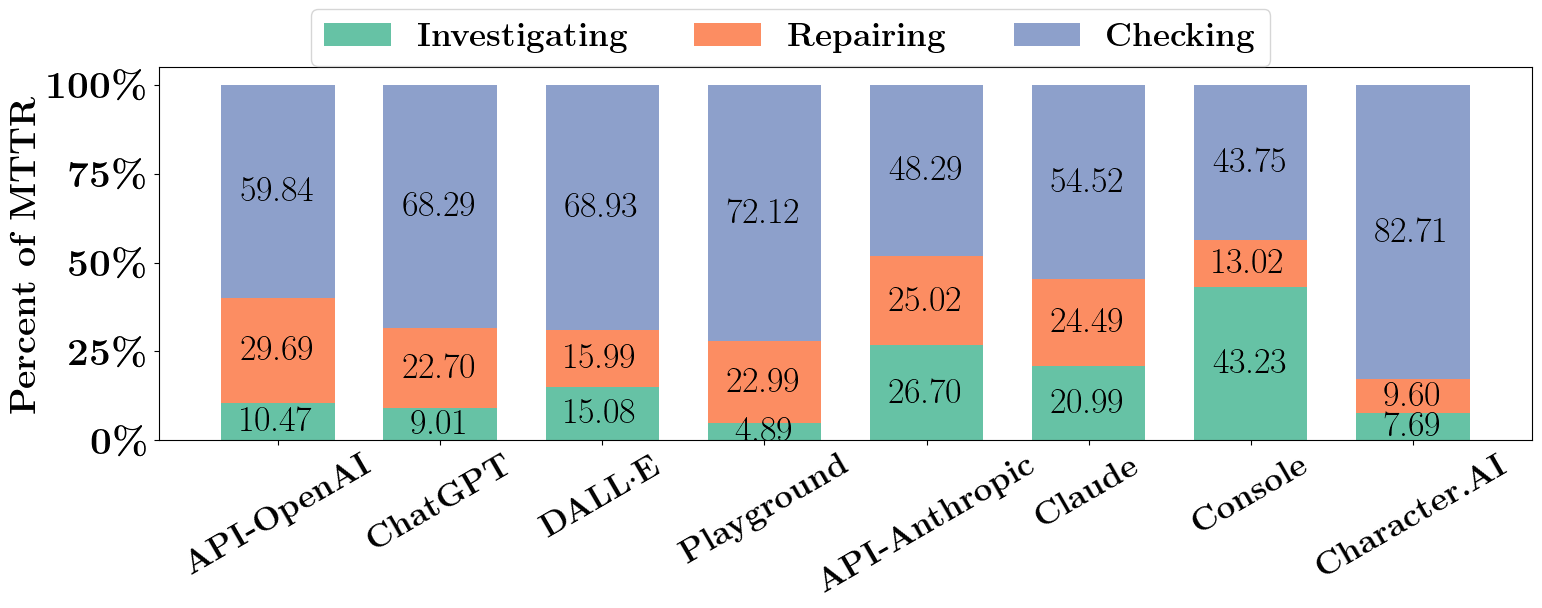

In [22]:
# plot stacked bar plot for each service
print('Figure. percent of MTTR for each service')
set_half_column_figure_font()
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
width = 0.7
x = np.arange(len(service_lst))
bottom = np.zeros(len(service_lst))
colors = sns.color_palette('Set2', n_colors=3)


for index, period in enumerate(['P_investigate', 'P_repair', 'P_check']):
    ax.bar(x, percent_df_MTTR[period], width, label=period, bottom=bottom, color=colors[index])
    # add percentage text in the middle of each bar, such as 0.00%
    for i, percent in enumerate(percent_df_MTTR[period]):
        ax.text(i, bottom[i] + percent / 2, f'{percent:.2%}%', ha='center', va='center', color='black')
    bottom += percent_df_MTTR[period]

ax.set_ylabel('Percentage')
ax.set_xticks(x)
x_tick_service_lst = [r'\textbf{API-OpenAI}', r'\textbf{ChatGPT}', r'\textbf{DALL·E}', r'\textbf{Playground}', r'\textbf{API-Anthropic}', r'\textbf{Claude}', r'\textbf{Console}', r'\textbf{Character.AI}']
ax.set_xticklabels(x_tick_service_lst)
handles, labels = ax.get_legend_handles_labels()
labels = [r'\textbf{Investigating}', r'\textbf{Repairing}', r'\textbf{Checking}']
ax.legend(labels=labels, bbox_to_anchor=(0.46, 1.2), loc = 'upper center', ncol=3)
plt.xticks(rotation=30)

ax.yaxis.set_major_formatter(PercentFormatter(1))
y_tick_lst = [r'\textbf{0\%}', r'\textbf{25\%}', r'\textbf{50\%}', r'\textbf{75\%}', r'\textbf{100\%}']
ax.set_yticklabels(y_tick_lst, fontsize=28)
ax.set_ylabel(r'\textbf{Percent of MTTR}')


plt.tight_layout()
plt.savefig('plot/sec4-failure_recovery/stacked-bar-percent-of-MTTR.pdf')
plt.show()


## Analysis of Mean Time To Reslove (MTTR)

In [4]:
# calculate the duration of each stage and add new columns
df = df.rename(columns={'API': 'API-OpenAI', 'ChatGPT': 'ChatGPT', 'Labs': 'DALL·E', 'Playground': 'Playground', 'api.anthropic.com': 'API-Anthropic', 'claude.ai': 'Claude', 'console.anthropic.com': 'Console', 'Character.AI': 'Character.AI'})
service_lst = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI']
dfs = {}
for service in service_lst:
    dfs[service] = df[df[service] == 1]
    # order by investigating_timestamp
    dfs[service] = dfs[service].sort_values(by='start_timestamp')
    dfs[service] = dfs[service].reset_index(drop=True)
for service in service_lst:
    dfs[service]['MTBF'] = dfs[service]['start_timestamp'].diff()
    dfs[service]['P_investigate'] = dfs[service]['identified_timestamp'] - dfs[service]['investigating_timestamp']
    dfs[service]['P_repair'] = dfs[service]['monitoring_timestamp'] - dfs[service]['identified_timestamp']
    dfs[service]['P_check'] = dfs[service]['resolved_timestamp'] - dfs[service]['monitoring_timestamp']
    dfs[service]['P_learn'] = dfs[service]['postmortem_timestamp'] - dfs[service]['resolved_timestamp']
    dfs[service]['MTTR'] = dfs[service]['resolved_timestamp'] - dfs[service][['investigating_timestamp', 'identified_timestamp', 'monitoring_timestamp']].min(axis=1)
    dfs[service] = dfs[service].reset_index(drop=True)

dfs['API-OpenAI'].head()

,incident_id,Incident_Title,incident_impact_level,Incident_color,provider,Playground,API-OpenAI,DALL·E,ChatGPT,API-Anthropic,Claude,Console,Character.AI,investigating_flag,investigating_timestamp,investigating_description,identified_flag,identified_timestamp,identified_description,monitoring_flag,monitoring_timestamp,monitoring_description,resolved_flag,resolved_timestamp,resolved_description,postmortem_flag,postmortem_timestamp,postmortem_description,start_timestamp,close_timestamp,time_span,over_one_day,MTBF,P_investigate,P_repair,P_check,P_learn,MTTR
0,v9c6hwjvywy8,Engine Listing Issues,1,#f4ac36,openai,0,1,0,0,0,0,0,0,0,NaT,NaN,1,2021-03-02 02:07:00+00:00,We are investigating an issue whereby listing ...,1,2021-03-02 02:13:00+00:00,Api engine listing appears to have returned to...,1,2021-03-02 02:17:00+00:00,Engine listing has returned to normal. We have...,0,NaT,NaN,2021-03-02 02:07:00+00:00,2021-03-02 02:17:00+00:00,0 days 00:10:00,False,NaT,NaT,0 days 00:06:00,0 days 00:04:00,NaT,0 days 00:10:00
1,njmxdd3rh3g9,Degraded API Status,1,#f4ac36,openai,1,1,0,0,0,0,0,0,1,2021-04-01 21:35:00+00:00,We are actively investigating a degradation in...,1,2021-04-01 21:48:00+00:00,We now believe that there is a widespread outa...,1,2021-04-01 22:47:00+00:00,DNS for api.openai.com should be properly reso...,1,2021-04-01 23:40:00+00:00,Marking this incident as resolved on our end. ...,0,NaT,NaN,2021-04-01 21:35:00+00:00,2021-04-01 23:40:00+00:00,0 days 02:05:00,False,30 days 19:28:00,0 days 00:13:00,0 days 00:59:00,0 days 00:53:00,NaT,0 days 02:05:00
2,5k0mvvx5pygs,API outage,3,#ef4146,openai,0,1,0,0,0,0,0,0,0,NaT,NaN,0,NaT,NaN,1,2021-06-17 04:44:00+00:00,We experienced a full outage for 4 minutes in ...,1,2021-06-17 05:22:00+00:00,This incident has been resolved.,0,NaT,NaN,2021-06-17 04:44:00+00:00,2021-06-17 05:22:00+00:00,0 days 00:38:00,False,76 days 07:09:00,NaT,NaT,0 days 00:38:00,NaT,0 days 00:38:00
3,05vgc7krfpz5,Intermittent instability with completion requests,1,#f4ac36,openai,0,1,0,0,0,0,0,0,0,NaT,NaN,1,2021-07-28 23:00:00+00:00,Requests to some models are getting more 429s ...,0,NaT,NaN,1,2021-07-29 02:18:00+00:00,This incident has been resolved.,0,NaT,NaN,2021-07-28 23:00:00+00:00,2021-07-29 02:18:00+00:00,0 days 03:18:00,False,41 days 18:16:00,NaT,NaT,NaT,NaT,0 days 03:18:00
4,2pjsp7khqlmz,Elevated API Errors,2,#e86c09,openai,1,1,0,0,0,0,0,0,1,2021-11-30 06:15:00+00:00,We're experiencing an elevated level of API er...,0,NaT,NaN,0,NaT,NaN,1,2021-11-30 11:22:00+00:00,Engine listing in the playground site and via ...,0,NaT,NaN,2021-11-30 06:15:00+00:00,2021-11-30 11:22:00+00:00,0 days 05:07:00,False,124 days 07:15:00,NaT,NaT,NaT,NaT,0 days 05:07:00


In [5]:
# data preparation for plotting
# keep only MTTR column
dfs_MTTR = {}
for service in service_lst:
    dfs_MTTR[service] = dfs[service]['MTTR']
    dfs_MTTR[service] = dfs_MTTR[service].map(lambda x: x.total_seconds() / 60 / 60)
display(dfs_MTTR['API-OpenAI'].head())

provider_lst = ['openai', 'anthropic', 'character']
dfs_provider = {}
for provider in provider_lst:
    for service in service_lst:
        if provider in dfs[service]['provider'].unique():
            dfs_provider[provider] = dfs_provider.get(provider, pd.DataFrame())
            dfs_provider[provider] = pd.concat([dfs_provider[provider], dfs[service][dfs[service]['provider'] == provider]], axis=0)
dfs_provider_MTTR = {}
for provider in provider_lst:
    dfs_provider_MTTR[provider] = dfs_provider[provider]['MTTR']
    dfs_provider_MTTR[provider] = dfs_provider_MTTR[provider].map(lambda x: x.total_seconds() / 60 / 60)
display(dfs_provider_MTTR['anthropic'].head())

0    0.166667
1    2.083333
2    0.633333
3    3.300000
4    5.116667
Name: MTTR, dtype: float64

0         NaN
1    2.916667
2         NaN
3    8.883333
4    1.150000
Name: MTTR, dtype: float64

MTTR grouped by service [hours], ECDF plot.


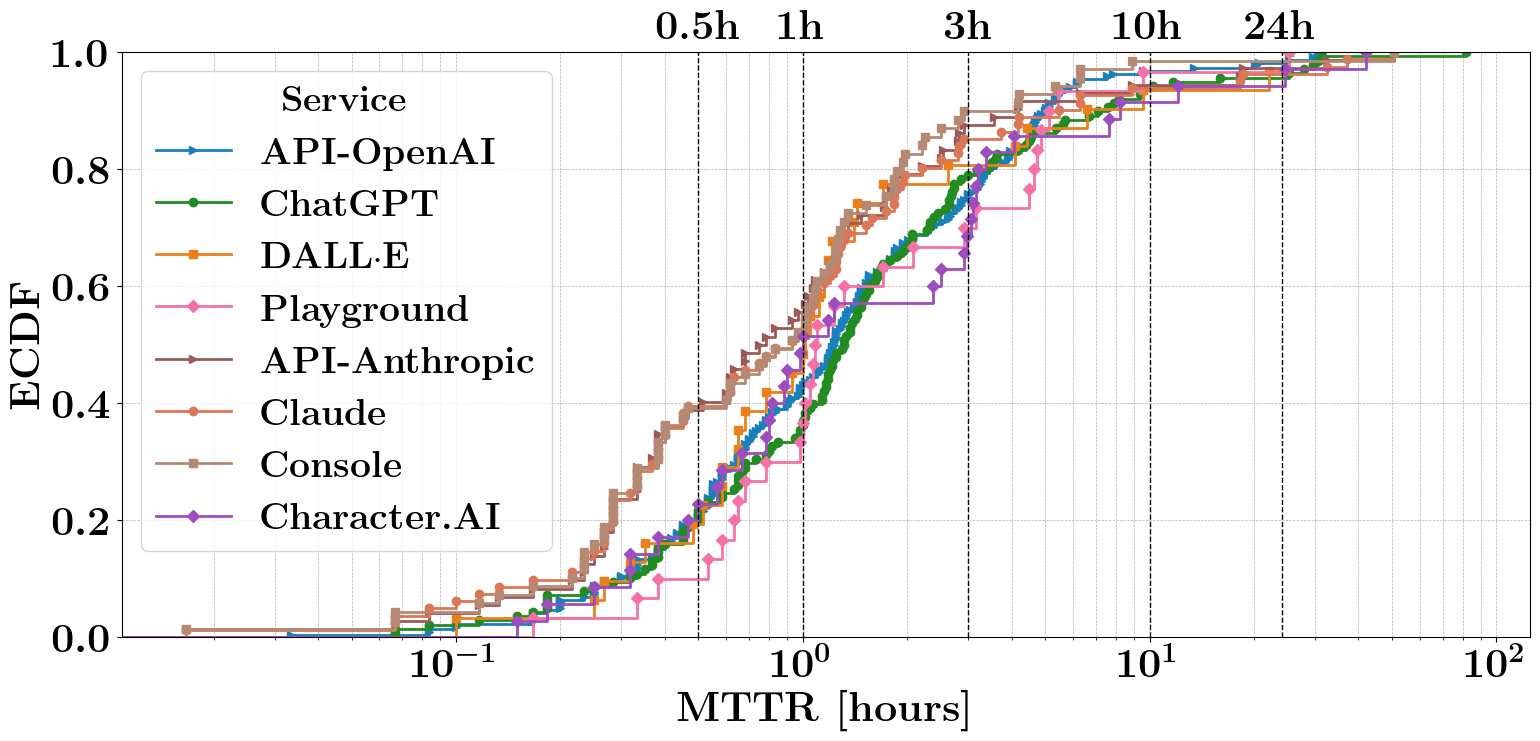

In [308]:
# MTTR grouped by service [hours], ECDF plot.
print('MTTR grouped by service [hours], ECDF plot.')
set_half_column_figure_font(height_multiplier=1.0)
fig, ax = plt.subplots(figsize=(16, 8))
colors = ['#1a80bb', '#228B22', '#ea801c', '#f571a6'] + ['#9c5959', '#da7756', '#b48a74'] + ['#9d4dbd']
markers = ['>', 'o', 's', 'D', '>', 'o', 's', 'D']

for service in service_lst:
    sns.ecdfplot(data=dfs_MTTR[service], label=service, ax=ax, color=colors.pop(0), marker=markers.pop(0), linestyle='-', linewidth=2)

# add line of 30 minute
ax.axvline(x=30/60, color='black', linestyle='--', linewidth=1)
ax.text(30/60, 1.01, r'\textbf{0.5h}', color='black', fontsize=30, ha='center', verticalalignment='bottom')
# add line of 1 hour
ax.axvline(x=1, color='black', linestyle='--', linewidth=1)
ax.text(1, 1.01, r'\textbf{1h}', color='black', fontsize=30, ha='center', verticalalignment='bottom')
# add line of 3 hours
ax.axvline(x=3, color='black', linestyle='--', linewidth=1)
ax.text(3, 1.01, r'\textbf{3h}', color='black', fontsize=30, ha='center', verticalalignment='bottom')
# add line of 10 hours
ax.axvline(x=10, color='black', linestyle='--', linewidth=1)
ax.text(10, 1.01, r'\textbf{10h}', color='black', fontsize=30, ha='center', verticalalignment='bottom')
# add line of 24 hours
ax.axvline(x=24, color='black', linestyle='--', linewidth=1)
ax.text(24, 1.01, r'\textbf{24h}', color='black', fontsize=30, ha='center', verticalalignment='bottom')

ax.set_xlabel(r'\textbf{MTTR [hours]}', fontsize=30)
ax.set_xscale('log')
ax.set_ylabel(r'\textbf{ECDF}', fontsize=30)
labels = [r'\textbf{API-OpenAI}', r'\textbf{ChatGPT}', r'\textbf{DALL·E}', r'\textbf{Playground}', r'\textbf{API-Anthropic}', r'\textbf{Claude}', r'\textbf{Console}', r'\textbf{Character.AI}']
ax.legend(title=r'\textbf{Service}', labels=labels, loc='upper left', fontsize=27)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('plot/sec4-failure_recovery/MTTR-grouped-by-service-ecdf.pdf')
plt.savefig('plot/sec4-failure_recovery/MTTR-grouped-by-service-ecdf.png')
plt.show()


In [182]:
# for observation
print('MTTR percent at 30 mins, 1 hour, 3 hours, 10 hours, 1 day.')
percent_dict = {}
for service in service_lst:
    percent_dict[service] = {}
    for threshold in [30/60, 1, 3, 10, 24]:
        percent_dict[service][threshold] = (dfs_MTTR[service] <= threshold).sum() / len(dfs_MTTR[service])
percent_df = pd.DataFrame(percent_dict)
percent_df = percent_df.T
percent_df = percent_df.reset_index()
percent_df = percent_df.rename(columns={'index': 'service'})
# percent of MTTR over 1 day
percent_dict = {}
for service in service_lst:
    percent_dict[service] = 1 - (dfs_MTTR[service] <= 24).sum() / len(dfs_MTTR[service])
percent_df['>1 day'] = percent_dict.values()
percent_df = percent_df.round(4)
display(percent_df)

MTTR percent at 30 mins, 1 hour, 3 hours, 10 hours, 1 day.


,service,0.5,1.0,3.0,10.0,24.0,>1 day
0,API-OpenAI,0.2026,0.4141,0.7269,0.9295,0.9427,0.0573
1,ChatGPT,0.2128,0.3617,0.7730,0.9149,0.9362,0.0638
2,DALL·E,0.1935,0.4839,0.8065,0.9355,0.9677,0.0323
3,Playground,0.0938,0.3438,0.6562,0.9062,0.9062,0.0938
4,API-Anthropic,0.3684,0.5263,0.8289,0.8947,0.9211,0.0789
5,Claude,0.3721,0.4884,0.8023,0.8837,0.9070,0.0930
6,Console,0.3750,0.5000,0.8611,0.9444,0.9444,0.0556
7,Character.AI,0.2286,0.5143,0.6857,0.9143,0.9429,0.0571


MTTR grouped by provider [hours], ECDF plot.


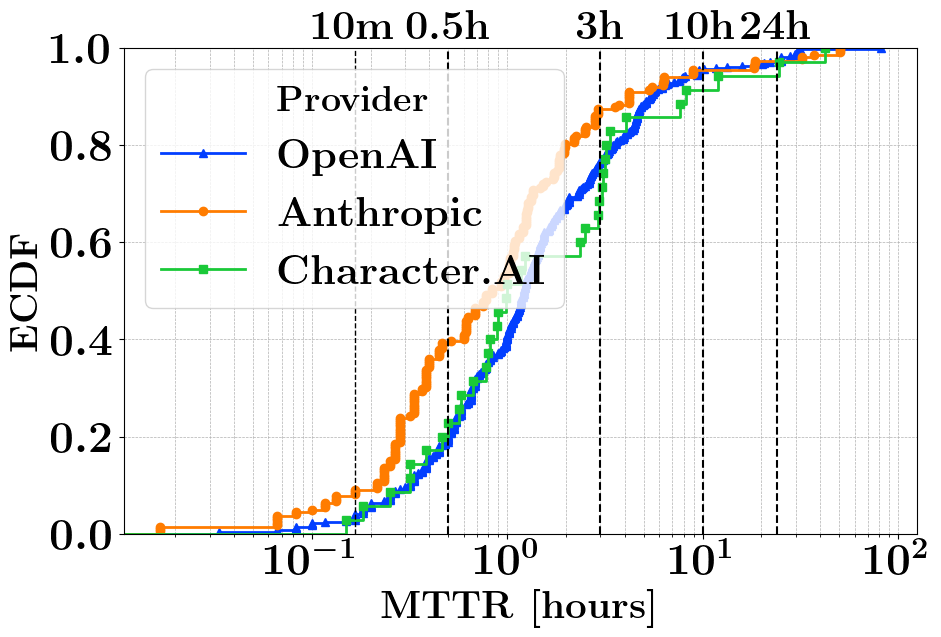

In [300]:
# MTTR grouped by provider [hours], ECDF plot.
print('MTTR grouped by provider [hours], ECDF plot.')
fig, ax = plt.subplots(figsize=(10, 7))
colors = sns.color_palette('bright', n_colors=3)
# colors = sns.color_palette('Greys', n_colors=5)
markers = ['^', 'o', 's']

for provider in provider_lst:
    sns.ecdfplot(data=dfs_provider_MTTR[provider], label=provider, ax=ax, color=colors.pop(0), marker=markers.pop(0), linestyle='-', linewidth=2)

# add line of 10 minute
ax.axvline(x=10/60, color='black', linestyle='--', linewidth=1)
ax.text(1/6, 1.08, r'\textbf{10m}', color='black', fontsize=30, ha='center', verticalalignment='top')
# add line of 0.5h
ax.axvline(x=0.5, color='black', linestyle='--', linewidth=1.5)
ax.text(0.5, 1.08, r'\textbf{0.5h}', color='black', fontsize=30, ha='center', verticalalignment='top')
# add line of 3 hours
ax.axvline(x=3, color='black', linestyle='--', linewidth=1.5)
ax.text(3, 1.08, r'\textbf{3h}', color='black', fontsize=30, ha='center', verticalalignment='top')
# add line of 10 hours
ax.axvline(x=10, color='black', linestyle='--', linewidth=1.5)
ax.text(10, 1.08, r'\textbf{10h}', color='black', fontsize=30, ha='center', verticalalignment='top')
# add line of 24 hours
ax.axvline(x=24, color='black', linestyle='--', linewidth=1.5)
ax.text(24, 1.08, r'\textbf{24h}', color='black', fontsize=30, ha='center', verticalalignment='top')

ax.set_xlabel(r'\textbf{MTTR [hours]}', fontsize=28)
ax.set_xscale('log')
ax.set_ylabel(r'\textbf{ECDF}', fontsize=28)
labels = [r'\textbf{OpenAI}', r'\textbf{Anthropic}', r'\textbf{Character.AI}']
ax.legend(title=r'\textbf{Provider}', labels=labels, loc='upper left', fontsize=30)
# set ticks size
ax.tick_params(axis='both', labelsize=32)
ax.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('plot/sec4-failure_recovery/MTTR-grouped-by-provider-ecdf.pdf')
plt.savefig('plot/sec4-failure_recovery/MTTR-grouped-by-provider-ecdf.png')
plt.show()

In [9]:
# for observation
display(dfs_provider_MTTR['openai'].describe())
display(dfs_provider_MTTR['anthropic'].describe())
display(dfs_provider_MTTR['character'].describe())

count    417.000000
mean       2.977058
std        6.333805
min        0.033333
25%        0.583333
50%        1.216667
75%        2.850000
max       81.783333
Name: MTTR, dtype: float64

count    222.000000
mean       2.700976
std        7.288218
min        0.016667
25%        0.333333
50%        0.833333
75%        1.825000
max       50.500000
Name: MTTR, dtype: float64

count    35.000000
mean      3.951905
std       8.070299
min       0.150000
25%       0.575000
50%       1.000000
75%       3.125000
max      42.183333
Name: MTTR, dtype: float64

In [183]:
# for observation   
print('MTTR percent at 10 mins, 30 mins, 1 hour, 3 hours, 10 hours, 1 day.')
percent_dict = {}
for provider in provider_lst:
    percent_dict[provider] = {}
    for threshold in [10/60, 30/60, 1, 3, 10, 24]:
        percent_dict[provider][threshold] = (dfs_provider_MTTR[provider] <= threshold).sum() / len(dfs_provider_MTTR[provider])
percent_df = pd.DataFrame(percent_dict)
percent_df = percent_df.T
percent_df = percent_df.reset_index()
percent_df = percent_df.rename(columns={'index': 'provider'})
# percent of MTTR over 1 day
percent_dict = {}
for provider in provider_lst:
    percent_dict[provider] = 1 - (dfs_provider_MTTR[provider] <= 24).sum() / len(dfs_provider_MTTR[provider])
percent_df['>1 day'] = percent_dict.values()
percent_df = percent_df.round(4)
display(percent_df)

MTTR percent at 10 mins, 30 mins, 1 hour, 3 hours, 10 hours, 1 day.


,provider,0.166667,0.5,1.0,3.0,10.0,24.0,>1 day
0,openai,0.0394,0.1972,0.3968,0.7425,0.9234,0.9397,0.0603
1,anthropic,0.0855,0.3718,0.5043,0.8291,0.9060,0.9231,0.0769
2,character,0.0286,0.2286,0.5143,0.6857,0.9143,0.9429,0.0571


Horizonal box plot by service, MTTR.


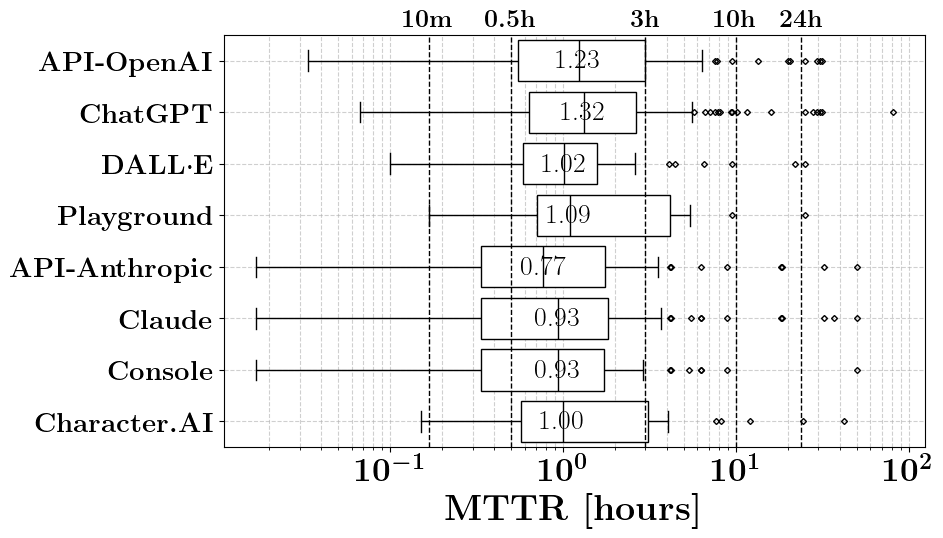

In [249]:
# plotting horizonal box plot by service, MTTR
print('Horizonal box plot by service, MTTR.')
set_half_column_figure_font(height_multiplier=1.0)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
labels = [r'\textbf{API-OpenAI}', r'\textbf{ChatGPT}', r'\textbf{DALL·E}', r'\textbf{Playground}', r'\textbf{API-Anthropic}', r'\textbf{Claude}', r'\textbf{Console}', r'\textbf{Character.AI}']
flierprops = dict(marker='D', markersize=3)
sns.boxplot(data=dfs_MTTR, orient='h', ax=ax, color='white', linecolor='black', flierprops=flierprops)
for patch in ax.artists:
    patch.set_edgecolor('black')   # Set the edge color to black
    patch.set_linewidth(2)         # Set the linewidth for the edgesk
# add text annotation for the median
for i, service in enumerate(service_lst):
    x = dfs_MTTR[service].median()
    ax.text(x, i, f'{x:.2f}', color='black', va='center', ha='center', fontsize=20)
# add line of 10 minute, 30 minute, 1 hour, 3 hours, 10 hours, 1 day
ax.axvline(x=10/60, color='black', linestyle='--', linewidth=1)
ax.text(10/60, -1, r'\textbf{10m}', color='black', fontsize=18, ha='center', verticalalignment='top')
ax.axvline(x=30/60, color='black', linestyle='--', linewidth=1)
ax.text(30/60, -1, r'\textbf{0.5h}', color='black', fontsize=18, ha='center', verticalalignment='top')
# ax.axvline(x=1, color='black', linestyle='--', linewidth=1)
# ax.text(1, -1, r'\textbf{1h}', color='black', fontsize=16, ha='center', verticalalignment='top')
ax.axvline(x=3, color='black', linestyle='--', linewidth=1)
ax.text(3, -1, r'\textbf{3h}', color='black', fontsize=18, ha='center', verticalalignment='top')
ax.axvline(x=10, color='black', linestyle='--', linewidth=1)
ax.text(10, -1, r'\textbf{10h}', color='black', fontsize=18, ha='center', verticalalignment='top')
ax.axvline(x=24, color='black', linestyle='--', linewidth=1)
ax.text(24, -1, r'\textbf{24h}', color='black', fontsize=18, ha='center', verticalalignment='top')

ax.set_yticklabels(labels, rotation=0, fontsize=20)
ax.set_yticklabels(labels)
ax.set_xlabel(r'\textbf{MTTR [hours]}')
ax.grid(axis='both', linestyle='--', alpha=0.6, which='both')
ax.set_xscale('log')
# x start from 0
# ax.set_xlim(0.1, 30)

plt.tight_layout()
plt.savefig('plot/sec4-failure_recovery/horizontal-box-plot-by-service-MTTR.pdf')
plt.savefig('plot/sec4-failure_recovery/horizontal-box-plot-by-service-MTTR.png')
plt.show()


In [14]:
(1.32-0.93)/0.93

0.41935483870967744

In [15]:
(1.23-0.77)/0.77

0.5974025974025974

## Analysis of Mean Time Between Failures (MTBF)

In [240]:
# calculate the duration of each stage and add new columns
df = df.rename(columns={'API': 'API-OpenAI', 'ChatGPT': 'ChatGPT', 'Labs': 'DALL·E', 'Playground': 'Playground', 'api.anthropic.com': 'API-Anthropic', 'claude.ai': 'Claude', 'console.anthropic.com': 'Console', 'Character.AI': 'Character.AI'})
service_lst = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI']
dfs = {}
for service in service_lst:
    dfs[service] = df[df[service] == 1]
    # order by investigating_timestamp
    dfs[service] = dfs[service].sort_values(by='start_timestamp')
    dfs[service] = dfs[service].reset_index(drop=True)
for service in service_lst:
    dfs[service]['MTBF'] = dfs[service]['start_timestamp'].diff()
    dfs[service]['P_investigate'] = dfs[service]['identified_timestamp'] - dfs[service]['investigating_timestamp']
    dfs[service]['P_repair'] = dfs[service]['monitoring_timestamp'] - dfs[service]['identified_timestamp']
    dfs[service]['P_check'] = dfs[service]['resolved_timestamp'] - dfs[service]['monitoring_timestamp']
    dfs[service]['P_learn'] = dfs[service]['postmortem_timestamp'] - dfs[service]['resolved_timestamp']
    dfs[service]['MTTR'] = dfs[service]['resolved_timestamp'] - dfs[service][['investigating_timestamp', 'identified_timestamp', 'monitoring_timestamp']].min(axis=1)
    dfs[service] = dfs[service].reset_index(drop=True)

dfs['API-OpenAI'].head()

,incident_id,Incident_Title,incident_impact_level,Incident_color,provider,Playground,API-OpenAI,DALL·E,ChatGPT,API-Anthropic,Claude,Console,Character.AI,investigating_flag,investigating_timestamp,investigating_description,identified_flag,identified_timestamp,identified_description,monitoring_flag,monitoring_timestamp,monitoring_description,resolved_flag,resolved_timestamp,resolved_description,postmortem_flag,postmortem_timestamp,postmortem_description,start_timestamp,close_timestamp,time_span,over_one_day,MTBF,P_investigate,P_repair,P_check,P_learn,MTTR
0,v9c6hwjvywy8,Engine Listing Issues,1,#f4ac36,openai,0,1,0,0,0,0,0,0,0,NaT,NaN,1,2021-03-02 02:07:00+00:00,We are investigating an issue whereby listing ...,1,2021-03-02 02:13:00+00:00,Api engine listing appears to have returned to...,1,2021-03-02 02:17:00+00:00,Engine listing has returned to normal. We have...,0,NaT,NaN,2021-03-02 02:07:00+00:00,2021-03-02 02:17:00+00:00,0 days 00:10:00,False,NaT,NaT,0 days 00:06:00,0 days 00:04:00,NaT,0 days 00:10:00
1,njmxdd3rh3g9,Degraded API Status,1,#f4ac36,openai,1,1,0,0,0,0,0,0,1,2021-04-01 21:35:00+00:00,We are actively investigating a degradation in...,1,2021-04-01 21:48:00+00:00,We now believe that there is a widespread outa...,1,2021-04-01 22:47:00+00:00,DNS for api.openai.com should be properly reso...,1,2021-04-01 23:40:00+00:00,Marking this incident as resolved on our end. ...,0,NaT,NaN,2021-04-01 21:35:00+00:00,2021-04-01 23:40:00+00:00,0 days 02:05:00,False,30 days 19:28:00,0 days 00:13:00,0 days 00:59:00,0 days 00:53:00,NaT,0 days 02:05:00
2,5k0mvvx5pygs,API outage,3,#ef4146,openai,0,1,0,0,0,0,0,0,0,NaT,NaN,0,NaT,NaN,1,2021-06-17 04:44:00+00:00,We experienced a full outage for 4 minutes in ...,1,2021-06-17 05:22:00+00:00,This incident has been resolved.,0,NaT,NaN,2021-06-17 04:44:00+00:00,2021-06-17 05:22:00+00:00,0 days 00:38:00,False,76 days 07:09:00,NaT,NaT,0 days 00:38:00,NaT,0 days 00:38:00
3,05vgc7krfpz5,Intermittent instability with completion requests,1,#f4ac36,openai,0,1,0,0,0,0,0,0,0,NaT,NaN,1,2021-07-28 23:00:00+00:00,Requests to some models are getting more 429s ...,0,NaT,NaN,1,2021-07-29 02:18:00+00:00,This incident has been resolved.,0,NaT,NaN,2021-07-28 23:00:00+00:00,2021-07-29 02:18:00+00:00,0 days 03:18:00,False,41 days 18:16:00,NaT,NaT,NaT,NaT,0 days 03:18:00
4,2pjsp7khqlmz,Elevated API Errors,2,#e86c09,openai,1,1,0,0,0,0,0,0,1,2021-11-30 06:15:00+00:00,We're experiencing an elevated level of API er...,0,NaT,NaN,0,NaT,NaN,1,2021-11-30 11:22:00+00:00,Engine listing in the playground site and via ...,0,NaT,NaN,2021-11-30 06:15:00+00:00,2021-11-30 11:22:00+00:00,0 days 05:07:00,False,124 days 07:15:00,NaT,NaT,NaT,NaT,0 days 05:07:00


In [10]:
# data preparation for plotting
# keep only MTBF column
dfs_MTBF = {}
for service in service_lst:
    dfs_MTBF[service] = dfs[service]['MTBF']
    dfs_MTBF[service] = dfs_MTBF[service].map(lambda x: x.total_seconds() / 60 / 60 / 24)  # convert to days
display(dfs_MTBF['API-OpenAI'].head())

provider_lst = ['openai', 'anthropic', 'character']
dfs_provider = {}
for provider in provider_lst:
    for service in service_lst:
        if provider in dfs[service]['provider'].unique():
            dfs_provider[provider] = dfs_provider.get(provider, pd.DataFrame())
            dfs_provider[provider] = pd.concat([dfs_provider[provider], dfs[service][dfs[service]['provider'] == provider]], axis=0)
dfs_provider_MTBF = {}
for provider in provider_lst:
    dfs_provider_MTBF[provider] = dfs_provider[provider]['MTBF']
    dfs_provider_MTBF[provider] = dfs_provider_MTBF[provider].map(lambda x: x.total_seconds() / 60 / 60 / 24)
display(dfs_provider_MTBF['anthropic'].head())

0           NaN
1     30.811111
2     76.297917
3     41.761111
4    124.302083
Name: MTBF, dtype: float64

0          NaN
1     1.973611
2     8.107639
3    59.965278
4    48.159028
Name: MTBF, dtype: float64

In [11]:
# average MTBF for each service
print('average MTBF for each service [days]')
mtbf_dict = {}
for service in service_lst:
    mtbf_dict[service] = dfs_MTBF[service].mean()
mtbf_df = pd.DataFrame(mtbf_dict.items(), columns=['service', 'MTBF'])
mtbf_df = mtbf_df.round(2)
display(mtbf_df)

# average MTBF for each provider
print('average MTBF for each provider [days]')
mtbf_provider_dict = {}
for provider in provider_lst:
    mtbf_provider_dict[provider] = dfs_provider_MTBF[provider].mean()
mtbf_provider_df = pd.DataFrame(mtbf_provider_dict.items(), columns=['provider', 'MTBF'])
mtbf_provider_df = mtbf_provider_df.round(2)
display(mtbf_provider_df)

average MTBF for each service [days]


,service,MTBF
0,API-OpenAI,5.64
1,ChatGPT,4.01
2,DALL·E,18.24
3,Playground,39.93
4,API-Anthropic,5.22
5,Claude,4.79
6,Console,5.73
7,Character.AI,8.74


average MTBF for each provider [days]


,provider,MTBF
0,openai,8.48
1,anthropic,5.22
2,character,8.74


MTBF grouped by service [days], ECDF plot.


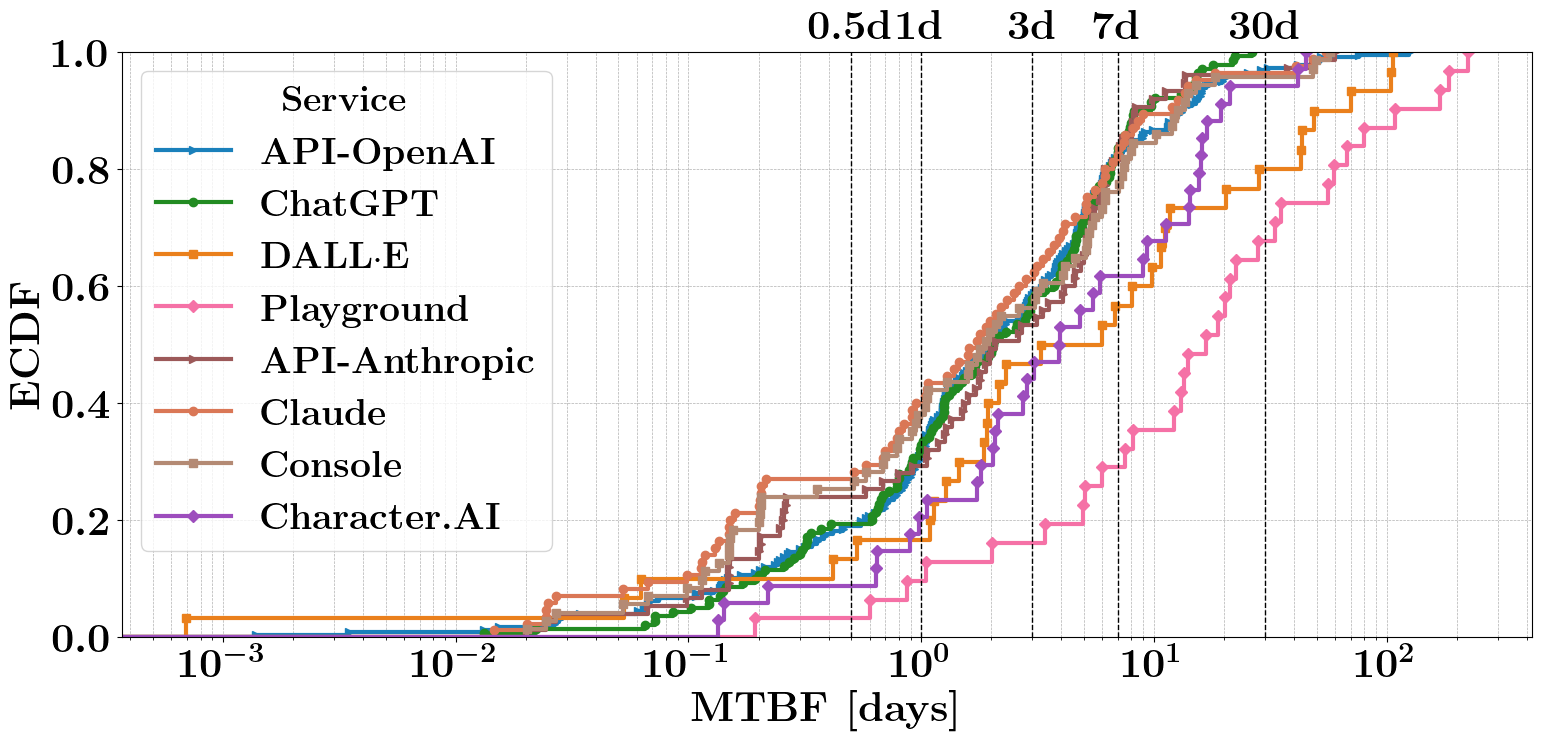

In [336]:
# MTBF grouped by service [days], ECDF plot.
print('MTBF grouped by service [days], ECDF plot.')
set_half_column_figure_font(height_multiplier=1.0)
fig, ax = plt.subplots(figsize=(16, 8))
colors = ['#1a80bb', '#228B22', '#ea801c', '#f571a6'] + ['#9c5959', '#da7756', '#b48a74'] + ['#9d4dbd']
markers = ['>', 'o', 's', 'D', '>', 'o', 's', 'D']
# colors = sns.color_palette('bright', n_colors=8)
# markers = ['o', 's', 'D', 'v', '^', '<', '>', 'x']

for service in service_lst:
    sns.ecdfplot(data=dfs_MTBF[service], label=service, ax=ax, color=colors.pop(0), marker=markers.pop(0), linestyle='-', linewidth=3)


# add line of 12 hours
ax.axvline(x=12/24, color='black', linestyle='--', linewidth=1)
ax.text(12/24, 1.01, r'\textbf{0.5d}', color='black', fontsize=30, ha='center',  verticalalignment='bottom')
# add line of 1 day
ax.axvline(x=1, color='black', linestyle='--', linewidth=1)
ax.text(1, 1.01, r'\textbf{1d}', color='black', fontsize=30, ha='center', verticalalignment='bottom')
# add line of 3 days
ax.axvline(x=3, color='black', linestyle='--', linewidth=1)
ax.text(3, 1.01, r'\textbf{3d}', color='black', fontsize=30, ha='center', verticalalignment='bottom')
# add line of 7 days
ax.axvline(x=7, color='black', linestyle='--', linewidth=1)
ax.text(7, 1.01, r'\textbf{7d}', color='black', fontsize=30, ha='center', verticalalignment='bottom')
# add line of 30 days
ax.axvline(x=30, color='black', linestyle='--', linewidth=1)
ax.text(30, 1.01, r'\textbf{30d}', color='black', fontsize=30, ha='center', verticalalignment='bottom')

ax.set_xlabel(r'\textbf{MTBF [days]}', fontsize=30)
ax.set_xscale('log')
ax.set_ylabel(r'\textbf{ECDF}', fontsize=30)
labels = [r'\textbf{API-OpenAI}', r'\textbf{ChatGPT}', r'\textbf{DALL·E}', r'\textbf{Playground}', r'\textbf{API-Anthropic}', r'\textbf{Claude}', r'\textbf{Console}', r'\textbf{Character.AI}']
ax.legend(title=r'\textbf{Service}', labels=labels, loc='upper left', fontsize=27)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('plot/sec3-failure_recovery/MTBF-grouped-by-service-ecdf.pdf')
plt.savefig('plot/sec3-failure_recovery/MTBF-grouped-by-service-ecdf.png')
plt.show()

In [190]:
# for observation
print('MTBF percent at 0.5 day, 1 day, 3 days, 1 week, 1 month.')
percent_dict = {}
for service in service_lst:
    percent_dict[service] = {}
    for threshold in [12/24, 1, 3, 7, 30]:
        percent_dict[service][threshold] = (dfs_MTBF[service] <= threshold).sum() / len(dfs_MTBF[service])
percent_df = pd.DataFrame(percent_dict)
percent_df = percent_df.T
percent_df = percent_df.reset_index()
percent_df = percent_df.rename(columns={'index': 'service'})
# percent of MTBF over 1 month
percent_dict = {}
for service in service_lst:
    percent_dict[service] = 1 - (dfs_MTBF[service] <= 30).sum() / len(dfs_MTBF[service])
percent_df['>1 month'] = percent_dict.values()
percent_df = percent_df.round(4)
display(percent_df)


MTBF percent at 0.5 day, 1 day, 3 days, 1 week, 1 month.


,service,0.5,1.0,3.0,7.0,30.0,>1 month
0,API-OpenAI,0.1894,0.3084,0.5815,0.8150,0.9648,0.0352
1,ChatGPT,0.1915,0.3262,0.5745,0.8156,0.9929,0.0071
2,DALL·E,0.1290,0.1613,0.4516,0.5484,0.7742,0.2258
3,Playground,0.0312,0.0938,0.1562,0.2812,0.6562,0.3438
4,API-Anthropic,0.2368,0.2895,0.5263,0.8026,0.9474,0.0526
5,Claude,0.2674,0.3953,0.6047,0.8023,0.9535,0.0465
6,Console,0.2500,0.3750,0.5556,0.7500,0.9444,0.0556
7,Character.AI,0.0857,0.2000,0.4286,0.6000,0.9143,0.0857


MTBF grouped by provider [days], ECDF plot.


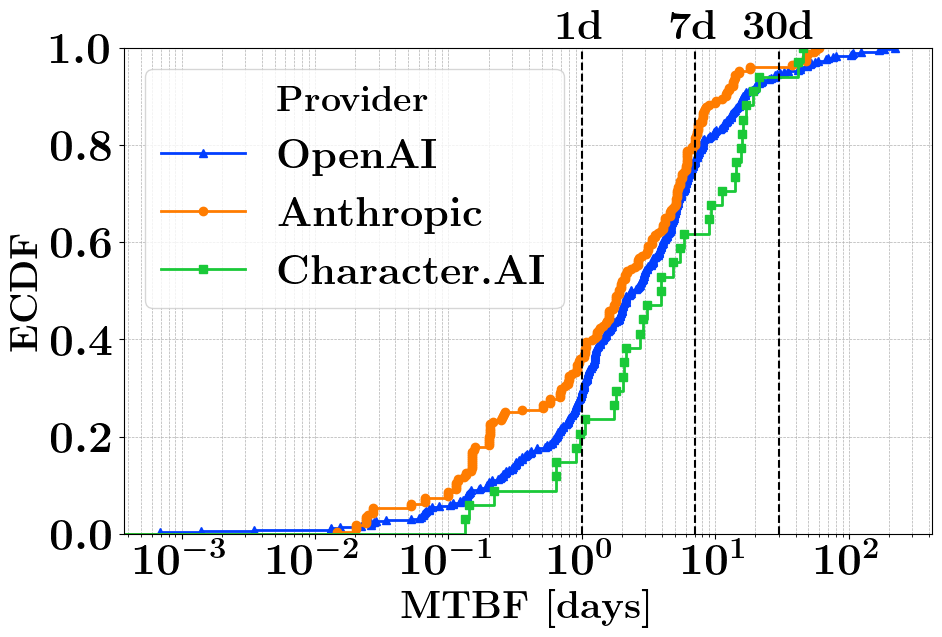

In [287]:
# MTBF grouped by provider [days], ECDF plot.
print('MTBF grouped by provider [days], ECDF plot.')
set_half_column_figure_font(height_multiplier=1.0)
fig, ax = plt.subplots(figsize=(10, 7))
colors = sns.color_palette('bright', n_colors=3)
# colors = sns.color_palette('Greys', n_colors=5)
markers = ['^', 'o', 's']

for provider in provider_lst:
    sns.ecdfplot(data=dfs_provider_MTBF[provider], label=provider, ax=ax, color=colors.pop(0), marker=markers.pop(0), linestyle='-', linewidth=2)

# add line of 1 day
ax.axvline(x=1, color='black', linestyle='--', linewidth=1.5)
ax.text(1, 1.08, r'\textbf{1d}', color='black', fontsize=30, ha='center', verticalalignment='top')
# add line of 7 days
ax.axvline(x=7, color='black', linestyle='--', linewidth=1.5)
ax.text(7, 1.08, r'\textbf{7d}', color='black', fontsize=30, ha='center', verticalalignment='top')
# add line of 30 days
ax.axvline(x=30, color='black', linestyle='--', linewidth=1.5)
ax.text(30, 1.08, r'\textbf{30d}', color='black', fontsize=30, ha='center', verticalalignment='top')

ax.set_xlabel(r'\textbf{MTBF [days]}', fontsize=28)
ax.set_xscale('log')
ax.set_ylabel(r'\textbf{ECDF}', fontsize=28)
labels = [r'\textbf{OpenAI}', r'\textbf{Anthropic}', r'\textbf{Character.AI}']
ax.legend(title=r'\textbf{Provider}', labels=labels, loc='upper left', fontsize=30)
# set ticks size
ax.tick_params(axis='both', labelsize=32)
ax.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('plot/sec3-failure_recovery/MTBF-grouped-by-provider-ecdf.pdf')
plt.savefig('plot/sec3-failure_recovery/MTBF-grouped-by-provider-ecdf.png')
plt.show()

In [12]:
# for observation
print('MTBF percent at 1 day, 7 days, 30 days, for provider.')
percent_dict = {}
for provider in provider_lst:
    percent_dict[provider] = {}
    for threshold in [1, 7, 30]:
        percent_dict[provider][threshold] = (dfs_provider_MTBF[provider] <= threshold).sum() / len(dfs_provider_MTBF[provider])
percent_df = pd.DataFrame(percent_dict)
percent_df = percent_df.T
percent_df = percent_df.reset_index()
percent_df = percent_df.rename(columns={'index': 'provider'})
# percent of MTBF over 1 month
percent_dict = {}
for provider in provider_lst:
    percent_dict[provider] = 1 - (dfs_provider_MTBF[provider] <= 30).sum() / len(dfs_provider_MTBF[provider])
percent_df['>1 month'] = percent_dict.values()
percent_df = percent_df.round(4)
display(percent_df)


MTBF percent at 1 day, 7 days, 30 days, for provider.


,provider,1,7,30,>1 month
0,openai,0.2877,0.7564,0.9374,0.0626
1,anthropic,0.3547,0.7863,0.9487,0.0513
2,character,0.2000,0.6000,0.9143,0.0857


Horizonal box plot by service, MTBF.


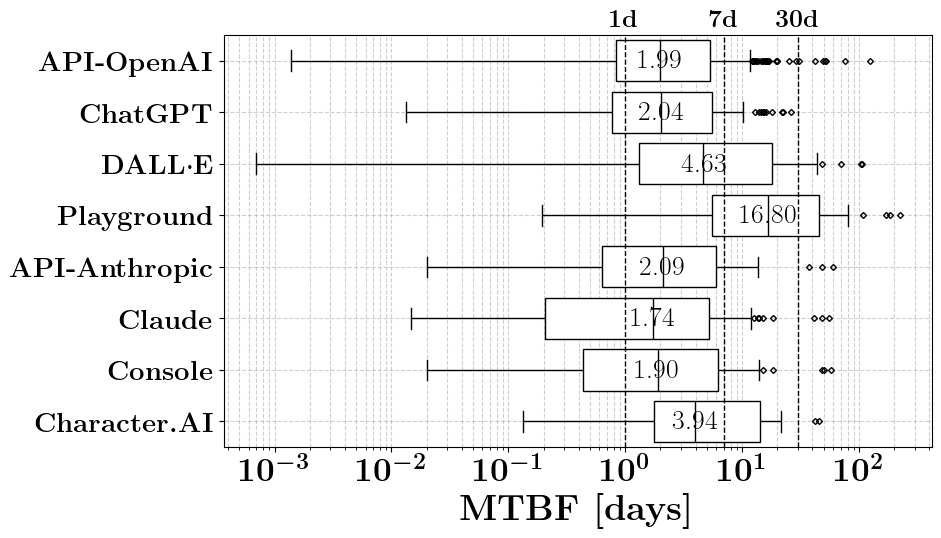

In [250]:
# plotting horizonal box plot by service, MTBF
print('Horizonal box plot by service, MTBF.')
set_half_column_figure_font(height_multiplier=1.0)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
labels = [r'\textbf{API-OpenAI}', r'\textbf{ChatGPT}', r'\textbf{DALL·E}', r'\textbf{Playground}', r'\textbf{API-Anthropic}', r'\textbf{Claude}', r'\textbf{Console}', r'\textbf{Character.AI}']
flierprops = dict(marker='D', markersize=3)
sns.boxplot(data=dfs_MTBF, orient='h', ax=ax, color='white', linecolor='black', flierprops=flierprops)
for patch in ax.artists:
    patch.set_edgecolor('black')   # Set the edge color to black
    patch.set_linewidth(2)         # Set the linewidth for the edgesk
# add text annotation for the median
for i, service in enumerate(service_lst):
    x = dfs_MTBF[service].median()
    ax.text(x, i, f'{x:.2f}', color='black', va='center', ha='center', fontsize=20)
# add line of 12 hours, 1 day, 3 days, 1 week, 1 month
ax.axvline(x=1, color='black', linestyle='--', linewidth=1)
ax.text(1, -1, r'\textbf{1d}', color='black', fontsize=18, ha='center', verticalalignment='top')
ax.axvline(x=7, color='black', linestyle='--', linewidth=1)
ax.text(7, -1, r'\textbf{7d}', color='black', fontsize=18, ha='center', verticalalignment='top')
ax.axvline(x=30, color='black', linestyle='--', linewidth=1)
ax.text(30, -1, r'\textbf{30d}', color='black', fontsize=18, ha='center', verticalalignment='top')

ax.set_yticklabels(labels, rotation=0, fontsize=20)
ax.set_xlabel(r'\textbf{MTBF [days]}')
ax.grid(axis='both', linestyle='--', alpha=0.6, which='both')
ax.set_xscale('log')
# x start from 0
# ax.set_xlim(0.1, 30)

plt.tight_layout()
plt.savefig('plot/sec3-failure_recovery/horizontal-box-plot-by-service-MTBF.pdf')
plt.savefig('plot/sec3-failure_recovery/horizontal-box-plot-by-service-MTBF.png')
plt.show()

In [17]:
16.80/1.74

9.655172413793103